<a href="https://colab.research.google.com/github/govardhan-06/practice-Notebooks/blob/main/pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

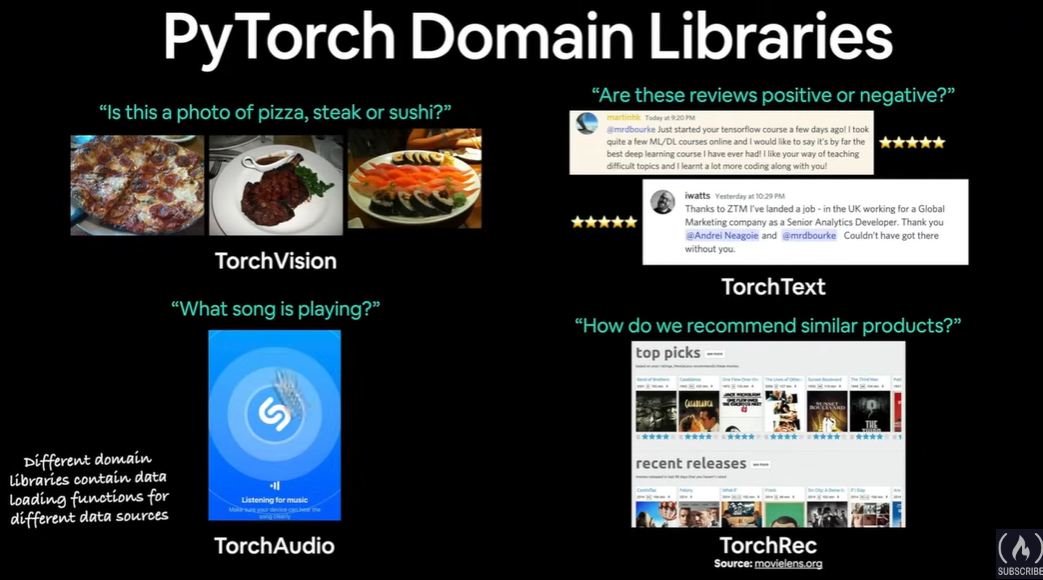

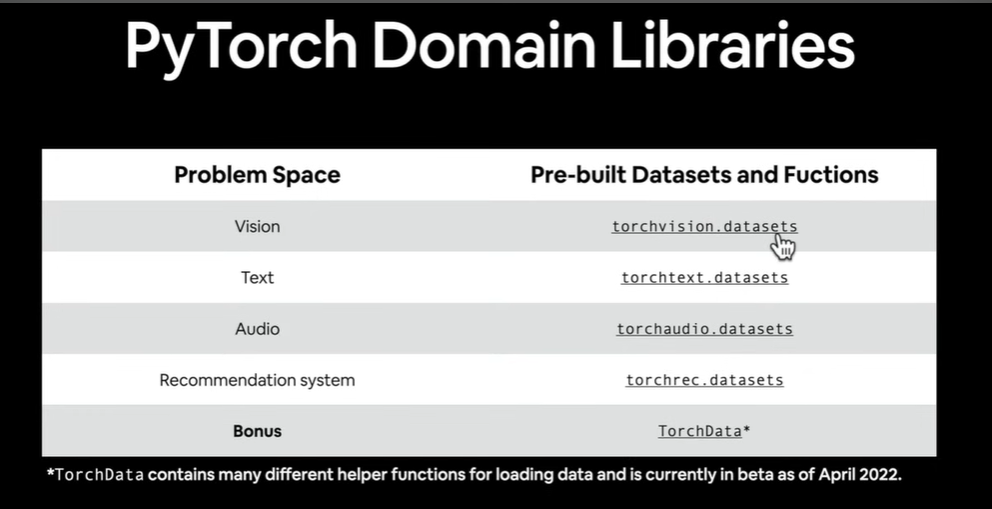

### Importing PyTorch and setting up the device agnotic code

In [65]:
import torch
from torch import nn

torch.__version__

'2.3.0+cu121'

In [66]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Getting the data

In [67]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


### Data Preparation, Data Exploration

In [68]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [69]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualizing the image

In [70]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/pizza/138855.jpg
Image class: pizza
Image height: 384
Image width: 512


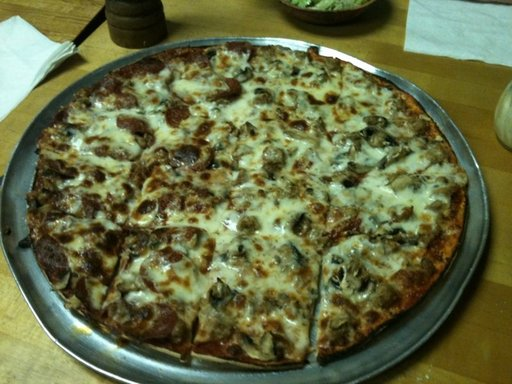

In [71]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

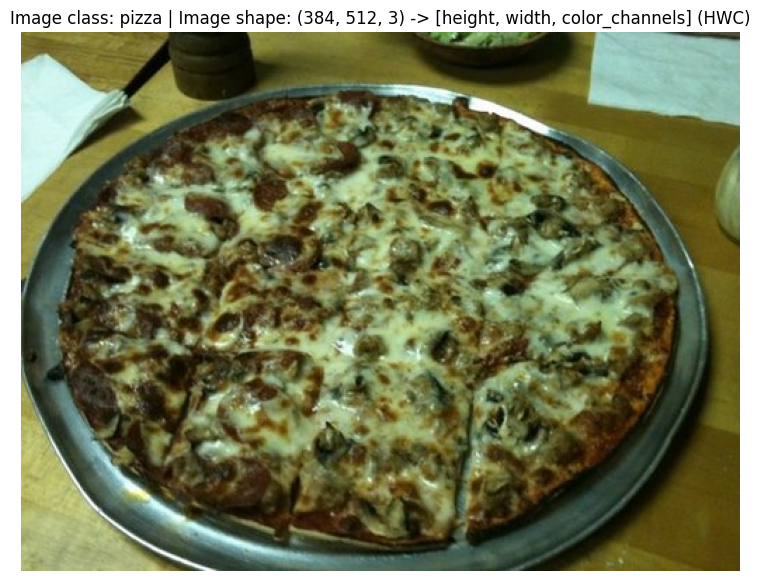

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

array([[[137, 132,  51],
        [129, 124,  43],
        [121, 116,  35],
        ...,
        [ 86,  78,  55],
        [ 88,  77,  55],
        [ 89,  78,  56]],

       [[120, 114,  36],
        [123, 117,  39],
        [129, 123,  45],
        ...,
        [ 84,  78,  56],
        [ 84,  76,  55],
        [ 84,  76,  55]],

       [[114, 106,  31],
        [118, 110,  35],
        [124, 116,  41],
        ...,
        [ 77,  75,  54],
        [ 81,  76,  56],
        [ 81,  76,  56]],

       ...,

       [[183, 190, 122],
        [184, 191, 123],
        [183, 190, 123],
        ...,
        [ 83,  67,   8],
        [ 81,  65,   6],
        [ 80,  64,   5]],

       [[176, 183, 116],
        [179, 186, 119],
        [178, 185, 118],
        ...,
        [ 85,  66,   7],
        [ 82,  66,   7],
        [ 81,  65,   6]],

       [[173, 180, 113],
        [176, 183, 116],
        [172, 179, 112],
        ...,
        [ 83,  64,   5],
        [ 80,  64,   5],
        [ 80,  64,   5]]], dtype=uint8)
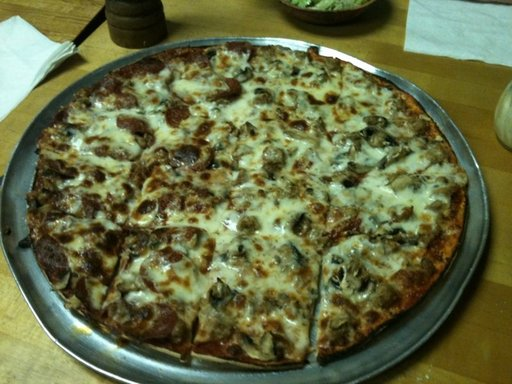

In [73]:
img_as_array

### Transforming data

In [74]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [75]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

In [76]:
data_transform(img).shape

torch.Size([3, 64, 64])

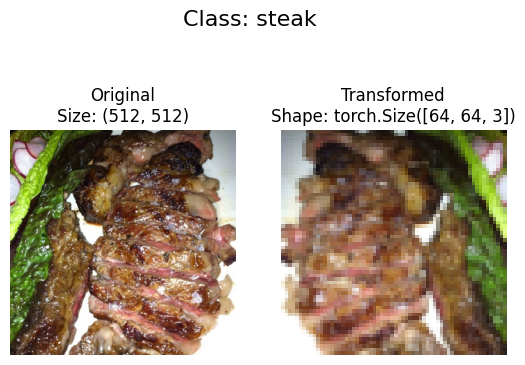

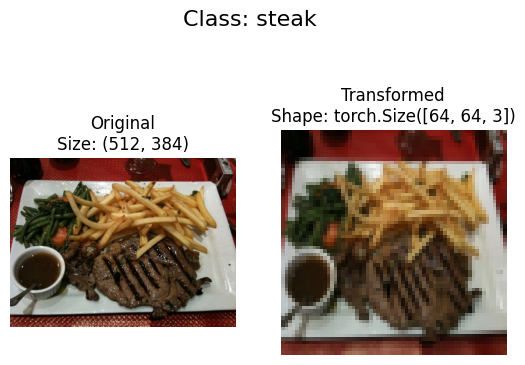

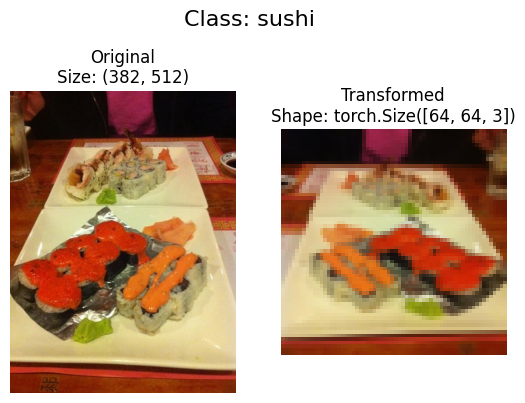

In [77]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

### Loading image

In [78]:
from torchvision import datasets

train_data= datasets.ImageFolder(root=train_dir, transform=data_transform,target_transform=None)
test_data= datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [79]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [80]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [81]:
#Get class names as dict
class_to_idx = train_data.class_to_idx
class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [82]:
#Check the length of dataset
len(train_data),len(test_data)

(225, 75)

In [83]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [84]:
train_data[0][0]

tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.

In [85]:
#Index on train_data Dataset to get a single image and label

image,label = train_data[0][0],train_data[0][1]

print(f"Image tensor: {img}")
print(f"Image shape: {image.shape}")
print(f"Image datatype: {image.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384 at 0x7D8FD6423A00>
Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 64, 64])
Image permuted shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

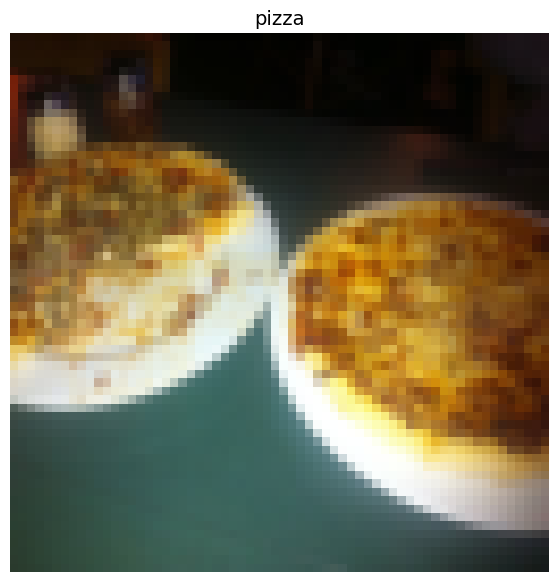

In [86]:
# Rearrange the order dimensions
img_permuted = image.permute(1,2,0)

#Print out different shapes
print(f"Original shape: {image.shape}")
print(f"Image permuted shape: {img_permuted.shape}")

#Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permuted)
plt.axis(False)
plt.title(class_names[label],fontsize=14)

### Turn loaded images into DataLoader's

In [87]:
import os
os.cpu_count()

2

In [88]:
#Turn the train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader= DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count())
test_dataloader= DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count())

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d8fd74545e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d8fd7455390>)

In [89]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [90]:
img,label = next(iter(train_dataloader))

#Batch size will now be 1 you can change the batch size if you like
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


### Creating custom datasets without using ImageFolder() of pytorch

In [91]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [92]:
#Instance of torchvision.datasets.ImageFolder()
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get the class names

Required Functions:
1. Get the class names using os.scandir() to traverse a target directory(this directory needs to be in the standard image classification format)
2. Raise an error if the class names are not found
3. Turn the class names into a dict and a list and return them

In [93]:
#Setup path for target directory
target_directory=train_dir
print(f"Target dir: {target_directory}")

#Getting the class names
class_names = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [94]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  '''
  Find the class folder names in the target directory
  '''
  class_names = sorted([entry.name for entry in list(os.scandir(directory))])

  if not class_names:
    raise FileNotFoundError(f"Could not find class names in {directory}")

  class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

  return class_names, class_to_idx

In [95]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`
1. Subclass `torch.utils.data.Dataset`
2. `Init our subclass` with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
* `paths` - paths of our images
* `transform` - the transform we'd like to use
* `classes` - a list of the target classes
* `class_to_idx`- a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [96]:
from torch.utils.data import Dataset

#Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  #Intialize custom dataset
  def __init__(self, target_dir: str, transform=None):
    #Create class attributes
    #Get all image paths
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))

    #Setup transform
    self.transform = transform

    #Get classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(target_dir)

  #Function to load the image
  def load_image(self, index:int) -> Image.Image:
    '''
    Opens an image via its path and returns it
    '''
    image_path = self.paths[index]
    return Image.open(image_path)

  #Overwrite the __len__()
  def __len__(self) -> int:
    return len(self.paths)

  #Overwrite the __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor,int]:
    '''
    Returns one sample of data, data and label (X,y)
    '''
    #Load the image
    image = self.load_image(index)

    class_name=self.paths[index].parent.name
    #path must be in this format: data_folder/class_name/image.jpg
    class_idx=self.class_to_idx[class_name]

    #Transform the image (if neccessary)
    if self.transform:
      image=self.transform(image)

    return image,class_idx
    #return data,label (X,y)

In [97]:
train_data[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [98]:
#Create a transform
from torchvision import transforms

train_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [99]:
#Test out ImageFolderCustom
train_data_custom=ImageFolderCustom(
    target_dir=train_dir,
    transform=train_transforms
)

test_data_custom=ImageFolderCustom(
    target_dir=test_dir,
    transform=test_transforms
)

In [100]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d8fd7454a00>,
 <__main__.ImageFolderCustom at 0x7d8fd74558d0>)

In [101]:
len(train_data), len(train_data_custom)

(225, 225)

In [102]:
len(test_data), len(test_data_custom)

(75, 75)

In [103]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [104]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [105]:
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### Displaying images at random
1. Take in a dataset and a number of other parameters such as class namesand how many images to visualize

2. To prevent the display getting out of hand, let's cap ht enumber of images to see at 10

3. Set the random seed for reproducibility

4. Get a list of random sample indexes from the target dataset.

5. Setup a matplotlib plot.

6. Loop through the random sample images and plot them with matploltib.

7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [106]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

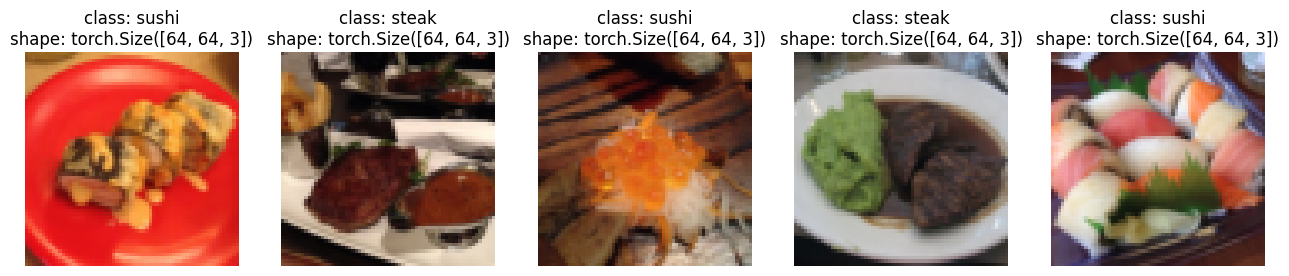

In [107]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

### Turn custom loaded images to DataLoader's

In [108]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
train_dataloader_custom=DataLoader(dataset=train_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=True)
test_dataloader_custom=DataLoader(dataset=test_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=False)
train_dataloader_custom,test_dataloader_custom


(<torch.utils.data.dataloader.DataLoader at 0x7d8fd66d2bf0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d8fd66d0040>)

In [109]:
img_custom,label_custom=next(iter(train_dataloader_custom))
img_custom.shape,label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### Data Augmentation
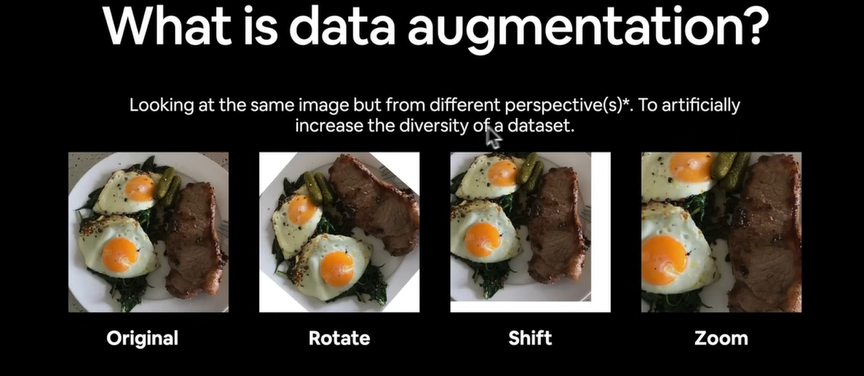

* Makes the model more generizable
* Trivial Augmentation

In [110]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
])

In [111]:
image_path_list

[PosixPath('data/pizza_steak_sushi/train/pizza/2228322.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/715169.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/138855.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/702165.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/928670.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1654444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/218711.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2026009.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1008844.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2291093.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2885050.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3821701.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1572608.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3505182.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2800325.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3860002.jpg'),
 PosixPath('d

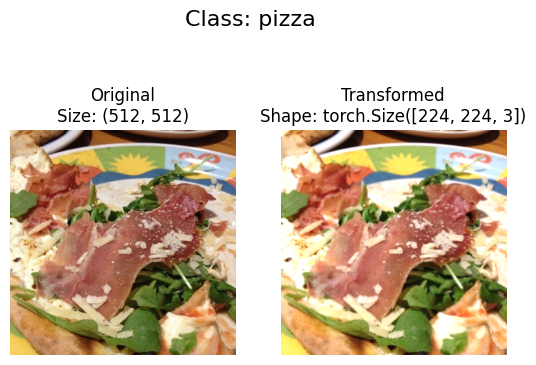

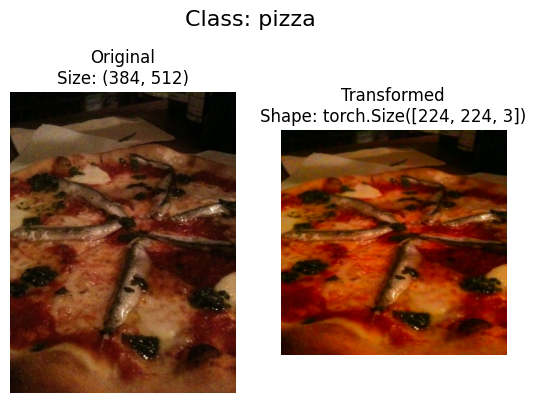

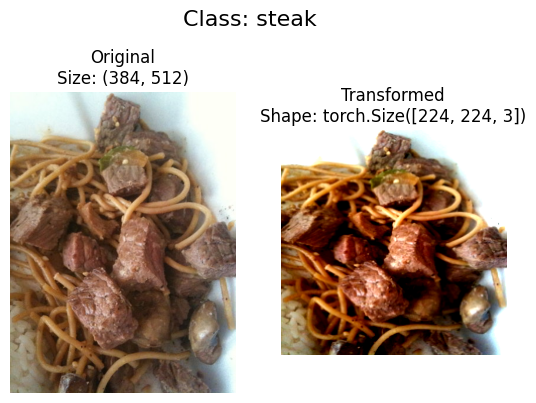

In [112]:
#Plot random transformd images
plot_transformed_images(
    image_path_list,
    train_transform,
    3,
    None
)

### Model0: TinyVGG without data augmentation

In [113]:
#Create simple transform
simple_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
])

In [114]:
#Load and transform data
from torchvision import datasets

train_data_simple=datasets.ImageFolder(root=train_dir,
                                       transform=simple_transform)
test_data_simple=datasets.ImageFolder(root=test_dir,transform=simple_transform)

#Turn the datasets into dataloaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

#Create DataLoader's
train_dataloader_simple=DataLoader(train_data_simple,
                                   batch_size=32,
                                   shuffle=True,
                                   num_workers=NUM_WORKERS)
test_dataloader_simple=DataLoader(test_data_simple,
                                  batch_size=32,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyVGG(nn.Module):
    '''
    Model Architecture from CNN explainer website
    '''
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Calculate the size of the feature maps after the convolutional layers
        self._calculate_conv_output_shape(input_shape)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.conv_output_size,
                      out_features=output_shape)
        )

    def _calculate_conv_output_shape(self, input_shape):
        # Create a dummy tensor with the same shape as the input to calculate the output size
        dummy_input = torch.zeros(1, input_shape, 224, 224)  # Updated input size
        dummy_output = self.conv_block_1(dummy_input)
        dummy_output = self.conv_block_2(dummy_output)
        self.conv_output_size = dummy_output.numel()

    def forward(self, x):
        x = self.conv_block_1(x)
        print(x.shape)
        x = self.conv_block_2(x)
        print(x.shape)
        x = self.classifier(x)
        print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [116]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3,
            hidden_units=10,
            output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=28090, out_features=3, bias=True)
  )
)

### Try a forward pass on a single image (to test the model)

In [117]:
#Get a single image batch
image_batch,label_batch=next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [118]:
#Try forward pass
model_0(image_batch.to(device))

torch.Size([32, 10, 110, 110])
torch.Size([32, 10, 53, 53])
torch.Size([32, 3])


tensor([[ 0.0351,  0.0035, -0.0037],
        [ 0.0401, -0.0002, -0.0068],
        [ 0.0352,  0.0008, -0.0047],
        [ 0.0360, -0.0024, -0.0052],
        [ 0.0345,  0.0059, -0.0034],
        [ 0.0421,  0.0064, -0.0071],
        [ 0.0379,  0.0057, -0.0015],
        [ 0.0321,  0.0023, -0.0027],
        [ 0.0340,  0.0024, -0.0014],
        [ 0.0383,  0.0038, -0.0048],
        [ 0.0356,  0.0027, -0.0047],
        [ 0.0371,  0.0039, -0.0055],
        [ 0.0374,  0.0071, -0.0031],
        [ 0.0340,  0.0070, -0.0039],
        [ 0.0379,  0.0030, -0.0059],
        [ 0.0379,  0.0045, -0.0057],
        [ 0.0373,  0.0062, -0.0065],
        [ 0.0374,  0.0024, -0.0042],
        [ 0.0346,  0.0045, -0.0023],
        [ 0.0369,  0.0051, -0.0073],
        [ 0.0330,  0.0049, -0.0021],
        [ 0.0301,  0.0041, -0.0038],
        [ 0.0400,  0.0064, -0.0047],
        [ 0.0398,  0.0081, -0.0045],
        [ 0.0323,  0.0031, -0.0042],
        [ 0.0378,  0.0067, -0.0056],
        [ 0.0376,  0.0072, -0.0042],
 

### `torchinfo` package - finding details about our model

In [119]:
!pip install torchinfo

In [120]:
from torchinfo import summary
summary(model_0,input_size=(1,3,224,224))

torch.Size([1, 10, 110, 110])
torch.Size([1, 10, 53, 53])
torch.Size([1, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 110, 110]         --
│    └─Conv2d: 2-1                       [1, 10, 222, 222]         280
│    └─ReLU: 2-2                         [1, 10, 222, 222]         --
│    └─Conv2d: 2-3                       [1, 10, 220, 220]         910
│    └─ReLU: 2-4                         [1, 10, 220, 220]         --
│    └─MaxPool2d: 2-5                    [1, 10, 110, 110]         --
├─Sequential: 1-2                        [1, 10, 53, 53]           --
│    └─Conv2d: 2-6                       [1, 10, 108, 108]         910
│    └─ReLU: 2-7                         [1, 10, 108, 108]         --
│    └─Conv2d: 2-8                       [1, 10, 106, 106]         910
│    └─ReLU: 2-9                         [1, 10, 106, 106]         --
│    └─MaxPool2d: 2-10                   [1, 10, 53, 53]           --
├─Sequentia

### Create train and test loops functions
* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and evaluates the model on the dataloader

In [121]:
#Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()

  train_loss,train_acc=0,0
  #Batch
  for batch,(X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)

    #Forward pass
    y_pred=model(X)

    #Loss function
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    #Optimizer zero grad
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=loss.item()

    #Optimizer step
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #Calculate accuracy metric
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

    #Adjust metrics to get average loss and accuracy per batch
    train_loss=train_loss/len(dataloader)
    train_acc=train_acc/len(dataloader)
    return train_loss,train_acc

In [122]:
def test_loop(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn=torch.nn.Module):
  model.eval()

  test_loss,test_acc=0,0

  with torch.inference_mode():
    #Loop
    for batch,(X,y) in enumerate(dataloader):
      X,y=X.to(device),y.to(device)

      #Forward pass
      test_pred_logits=model(X)

      #Calculate loss
      test_loss+=loss_fn(test_pred_logits,y).item()

      #Calculate accuracy
      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)

    #Adjust metrics to get avg loss and accuracy for each batch
    test_loss=test_loss/len(dataloader)
    test_acc=test_acc/len(dataloader)
    return test_loss,test_acc

### Creating the train function to combine `test_step()` and `train_step()`

In [123]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module,
          epochs: int=5,
          device=device):
  #Creating the results dictionary
  results={
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  #Training loop
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer)
    test_loss,test_acc=test_loop(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn)

    #What's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")

    #Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  #Returning the results
  return results

In [139]:
#Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set number of epochs
NUM_EPOCHS=5

#Recreate an instance of TinyVGG
model_0=TinyVGG(input_shape=3,
            hidden_units=10,
            output_shape=len(class_names)).to(device)

#Create optimizer
optimizer=torch.optim.Adam(params=model_0.parameters(),
                           lr=0.001)
#loss function
loss_fn=torch.nn.CrossEntropyLoss()

#Start the timer
from timeit import default_timer as timer
start_time=timer()

model_1_results=train(model=model_0,
                  train_dataloader=train_dataloader_simple,
                  test_dataloader=test_dataloader_simple,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=NUM_EPOCHS)

#End the timer
end_time=timer()
print(f"Time taken: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 10, 110, 110])
torch.Size([32, 10, 53, 53])
torch.Size([32, 3])
torch.Size([32, 10, 110, 110])
torch.Size([32, 10, 53, 53])
torch.Size([32, 3])
torch.Size([32, 10, 110, 110])
torch.Size([32, 10, 53, 53])
torch.Size([32, 3])
torch.Size([11, 10, 110, 110])
torch.Size([11, 10, 53, 53])
torch.Size([11, 3])
Epoch: 0 | Train loss: 0.1375 | Train acc: 0.1727 | Test acc: 0.2576
torch.Size([32, 10, 110, 110])
torch.Size([32, 10, 53, 53])
torch.Size([32, 3])
torch.Size([32, 10, 110, 110])
torch.Size([32, 10, 53, 53])
torch.Size([32, 3])
torch.Size([32, 10, 110, 110])
torch.Size([32, 10, 53, 53])
torch.Size([32, 3])
torch.Size([11, 10, 110, 110])
torch.Size([11, 10, 53, 53])
torch.Size([11, 3])
Epoch: 1 | Train loss: 0.1914 | Train acc: 0.2422 | Test acc: 0.2576
torch.Size([32, 10, 110, 110])
torch.Size([32, 10, 53, 53])
torch.Size([32, 3])
torch.Size([32, 10, 110, 110])
torch.Size([32, 10, 53, 53])
torch.Size([32, 3])
torch.Size([32, 10, 110, 110])
torch.Size([32, 10, 53, 53])
to

### Plotting the loss curves

In [125]:
def plot_loss_curves(results: Dict[str,List[float]]):
  '''
  Plots training and test loss curves
  '''

  #Get the loss values of the result dictionary
  loss=results["train_loss"]
  test_loss=results["test_loss"]

  #Get the accuracy values of the result dictionary
  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]

  #To find the nmber of epochs
  epochs=range(len(results["train_loss"]))

  #Setup a plot
  plt.figure(figsize=(15,7))

  #Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label='train_loss')
  plt.plot(epochs,test_loss,label='test_loss')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  #Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label='train_accuracy')
  plt.plot(epochs,test_accuracy,label='test_accuracy')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

In [126]:
model_1_results

{'train_loss': [0.13750192523002625,
  0.19143706560134888,
  0.15209610760211945,
  0.1358126550912857,
  0.14130569994449615,
  0.14591625332832336,
  0.13212834298610687,
  0.14753501117229462,
  0.13712652027606964,
  0.14009886980056763,
  0.1641930639743805,
  0.1487397700548172,
  0.13574090600013733,
  0.13794143497943878,
  0.14839103817939758,
  0.13976897299289703,
  0.13085892796516418,
  0.1402370184659958,
  0.14320987462997437,
  0.1369737982749939,
  0.14386531710624695,
  0.13635891675949097,
  0.13563060760498047,
  0.13163062930107117,
  0.1380082368850708,
  0.14225061237812042,
  0.14126382768154144,
  0.13936731219291687,
  0.13393758237361908,
  0.13533666729927063,
  0.13564758002758026,
  0.13475745916366577,
  0.1322776973247528,
  0.13266140222549438,
  0.12076260894536972,
  0.1286470890045166,
  0.12962068617343903,
  0.13402296602725983,
  0.13075996935367584,
  0.12251874059438705,
  0.12767164409160614,
  0.12679259479045868,
  0.12023697048425674,
  0.1

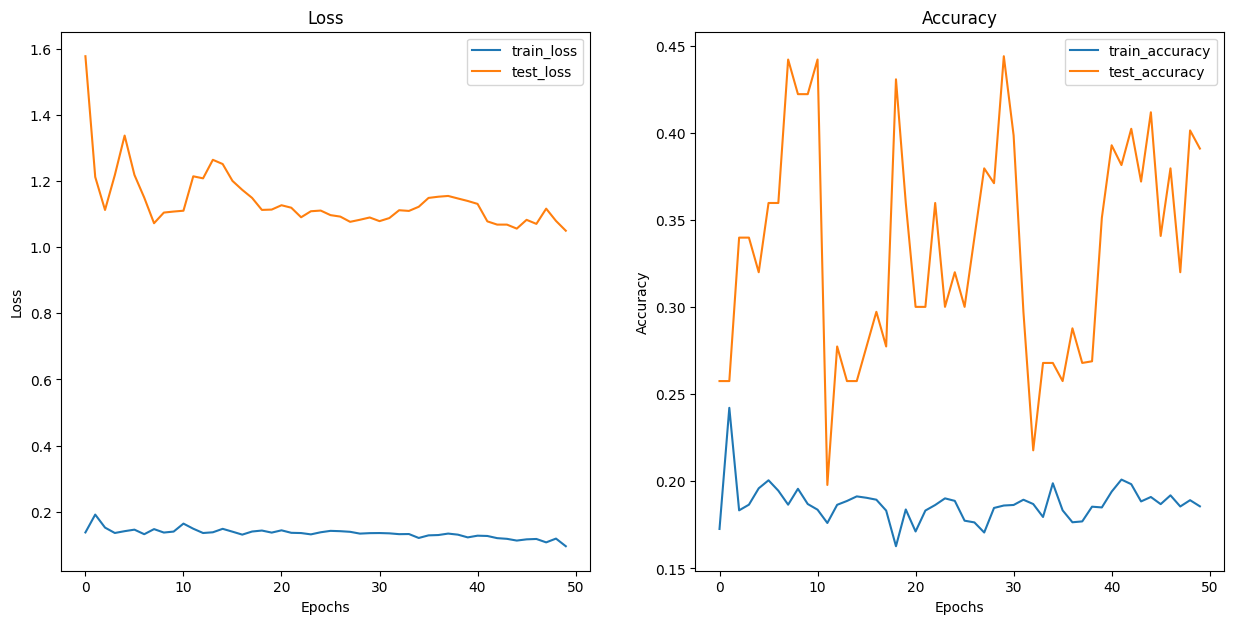

In [127]:
plot_loss_curves(model_1_results)

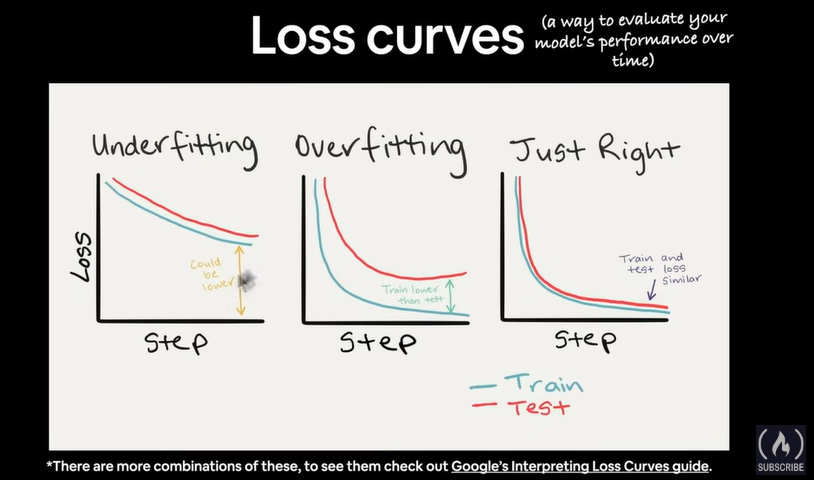

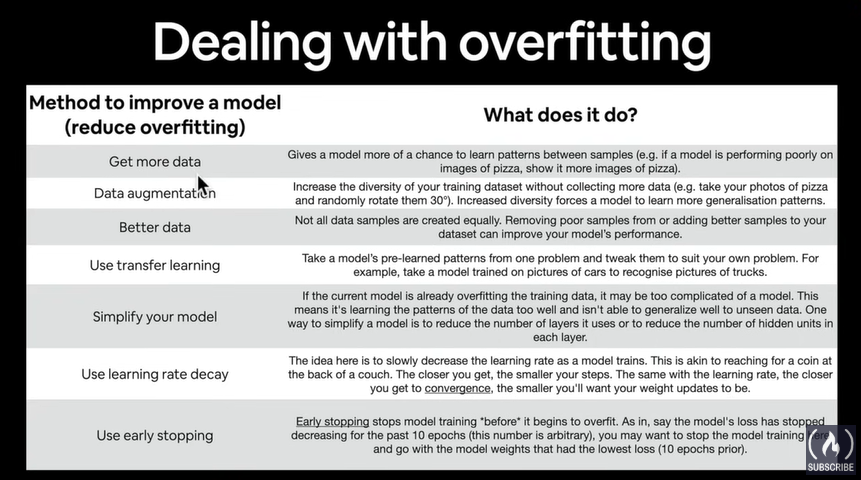

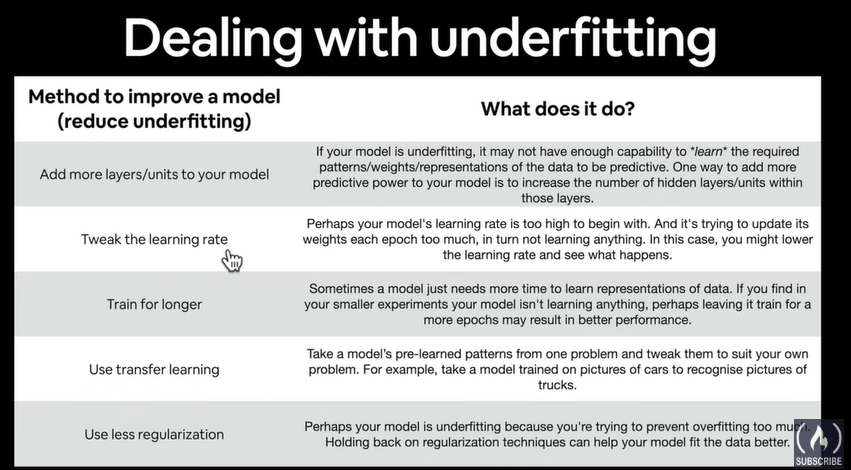

### Create transform with data augmentation

In [128]:
from torchvision import transforms

train_transform_trivial=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transform_simple=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [129]:
from torchvision import datasets
train_data_augmented=datasets.ImageFolder(root=train_dir,
                                          transform=train_transform_trivial)
test_data=datasets.ImageFolder(root=test_dir,
                               transform=test_transform_simple)

In [132]:
#Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

batch_size=1
num_workers=os.cpu_count()

train_loader_augmented=DataLoader(dataset=train_data_augmented,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  shuffle=True)

test_loader_augmented=DataLoader(dataset=test_data,
                       batch_size=batch_size,
                       num_workers=num_workers,
                       shuffle=False)


### Construct and train model 1

In [133]:
#Create model_1 and send it to target device
model2=TinyVGG(input_shape=3,
               hidden_units=10,
               output_shape=len(train_data_augmented.classes)).to(device)

model2

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=28090, out_features=3, bias=True)
  )
)

In [ ]:
#set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS=5

optimizer=torch.optim.Adam(params=model2.parameters(),
                           lr=0.001)

loss_fn=torch.nn.CrossEntropyLoss()

from timeit import default_timer as timer
start_time=timer()

model_2_results=train(model=model2,
                      train_dataloader=train_loader_augmented,
                      test_dataloader=test_loader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      device=device,
                      epochs=NUM_EPOCHS
                      )

end_time=timer()
total_time=end_time-start_time
print(f"Total training time: {total_time:.3f} seconds")

### Making a predict on a custom image

In [140]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.exists():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print("Downloading custom image...")
        f.write(request.content)
else:
    print("Custom image already exists.")


In [141]:
str(custom_image_path)

'data/04-pizza-dad.jpeg'

In [143]:
import torchvision

custom_image_uint8=torchvision.io.read_image(str(custom_image_path))
print(f"Custom image dimensions: {custom_image_uint8.shape}")
print(f"Custom image dtype: {custom_image_uint8.dtype}")
print(f"Custom image tensor: {custom_image_uint8}")

Custom image dimensions: torch.Size([3, 4032, 3024])
Custom image dtype: torch.uint8
Custom image tensor: tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], 

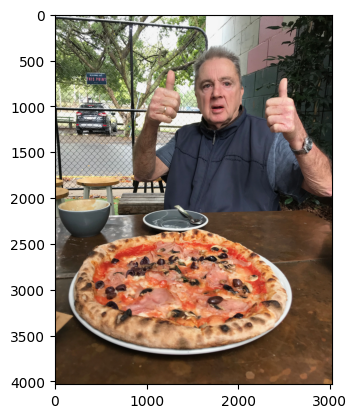

In [144]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### Making predicitions on the custom image with our model

In [151]:
#Converting the custom image to torch.float32
custom_image_float32=custom_image_uint8.type(torch.float32)/255

custom_image_float32

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [152]:
model_0.eval()
with torch.inference_mode():
    custom_image_pred=model_0(custom_image_float32.to(device))

torch.Size([10, 2014, 1510])
torch.Size([10, 1005, 753])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 28090x3)

In [155]:
#Create a transform pipeline to resize Image
from torchvision import transforms
custom_image_transform=transforms.Compose([
    transforms.Resize(size=(64,64))
])
custom_image_transformed=custom_image_transform(custom_image_uint8)

print(f"Original shape: {custom_image_uint8.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


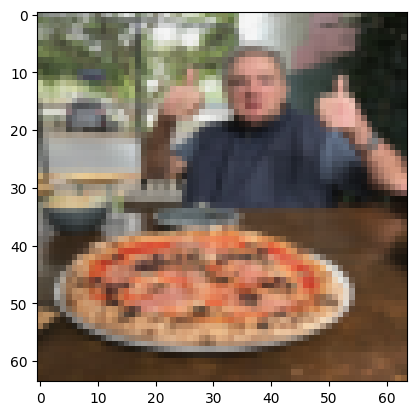

In [156]:
plt.imshow(custom_image_transformed.permute(1,2,0))